issue: https://github.com/ioos/notebooks_demos/issues/351

GTS Statistics

The GTS monthly reports show the number of messages released to the GTS for each station. The reports contain the following fields:

Location ID - Identifier that station messages are released under to the GTS
Region - Designated IOOS Regional Association (only for IOOS regional report)
Sponsor - Organization that owns and maintains the station
Met - Total number of met messages released to the GTS
Wave - Total number of wave messages released to the GTS

In [1]:
from datetime import date
from erddapy import ERDDAP


# currently the ERDDAP server has data from
# 2019-01-01T00:00:00Z to 2020-06-01T00:00:00Z
min_date = "2019-01-01T00:00:00Z"
max_date = "2020-06-01T00:00:00Z"

protocol = "tabledap"
server = "https://ferret.pmel.noaa.gov/generic/erddap"

e = ERDDAP(server=server, protocol=protocol)

e.dataset_id = "ioos_obs_counts"
e.variables = ["time", "locationID", "region", "sponsor", "met", "wave"]
e.constraints = {
    "time>=": min_date,
}

In [2]:
df = e.to_pandas()
df

,time (UTC),locationID,region,sponsor,met,wave
0,2019-01-01T00:00:00Z,46108,AOOS,ALASKA OCEAN OBSERVING SYSTEM,0.0,2620
1,2019-01-01T00:00:00Z,NKLA2,AOOS,MARINE EXCHANGE OF ALASKA,8836.0,0
2,2019-01-01T00:00:00Z,AJXA2,AOOS,MARINE EXCHANGE OF ALASKA,8824.0,0
3,2019-01-01T00:00:00Z,LIXA2,AOOS,MARINE EXCHANGE OF ALASKA,8842.0,0
4,2019-01-01T00:00:00Z,SCXA2,AOOS,MARINE EXCHANGE OF ALASKA,8840.0,0
...,...,...,...,...,...,...
3006,2020-06-01T00:00:00Z,41029,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1440.0,0
3007,2020-06-01T00:00:00Z,41037,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1436.0,0
3008,2020-06-01T00:00:00Z,41064,SECOORA,COASTAL OCEAN RESEARCH AND MONITORING PROGRAM,1218.0,0
3009,2020-06-01T00:00:00Z,SIPF1,SECOORA,FLORIDA INSTITUTE OF TECHNOLOGY,5570.0,0


# By region

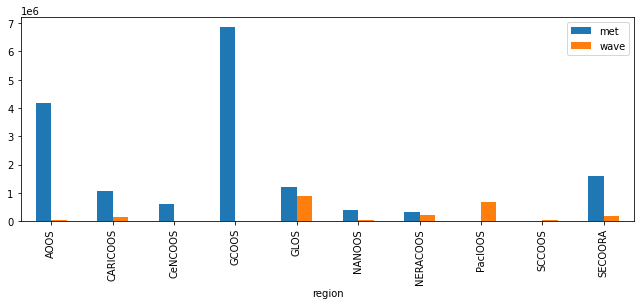

In [3]:
groups = df.groupby("region")

ax = groups.sum().plot(kind="bar", figsize=(11, 3.75))

In [4]:
import pandas as pd


df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
groups = df.groupby(pd.Grouper(key="time (UTC)", freq="M"))

# By month per variable

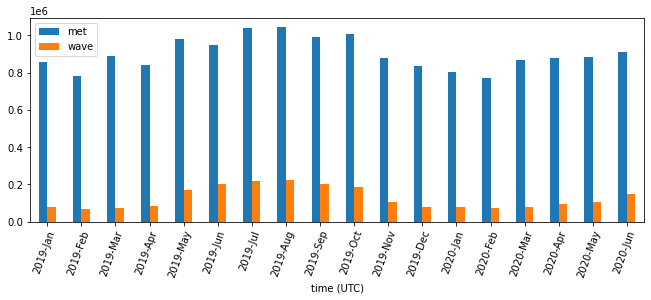

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(11, 3.75))

s = groups.sum()
s.plot(ax=ax, kind="bar")

ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"), rotation=70, rotation_mode="anchor", ha="right"
);

# By month totals

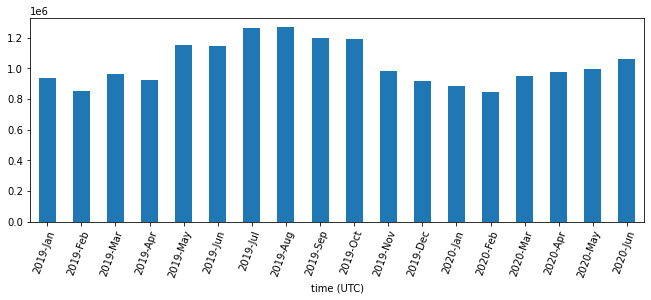

In [6]:
fig, ax = plt.subplots(figsize=(11, 3.75))

s = groups.sum().sum(axis=1)
s.plot(ax=ax, kind="bar")

ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"), rotation=70, rotation_mode="anchor", ha="right"
);

# By location

In [7]:
groups = df.groupby("locationID")

location_sum = groups.sum().sum(axis=1)
# ax = groups.sum().plot(kind="bar", figsize=(11, 3.75))

In [8]:
location_sum.sort_values(ascending=False, inplace=True)

In [9]:
print(f"There are {len(set(df['locationID']))} stations, filtering those that have 0 entries.")

There are 182 stations, filtering those that have 0 entries.


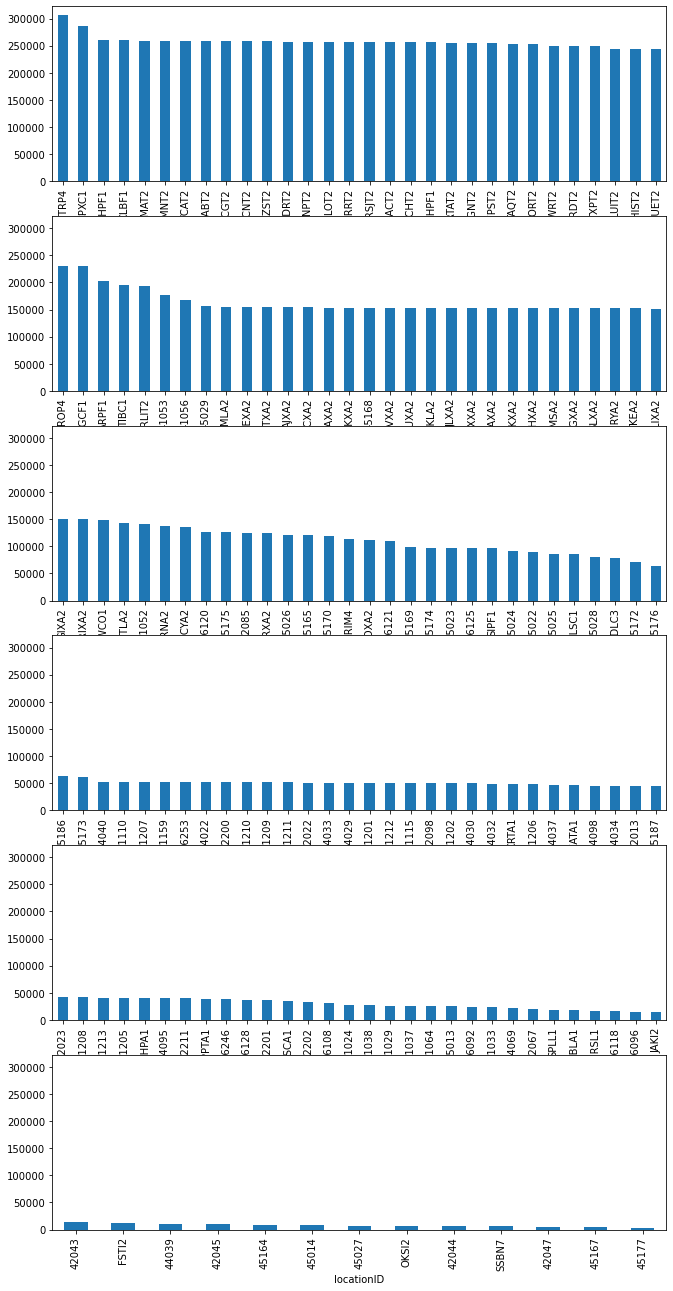

In [10]:
non_zero = location_sum.loc[location_sum > 0]

rows = 6
st = 30

fig, axes = plt.subplots(
    figsize=(11, 3.75*rows),
    nrows=6,
    sharey=True,
)

non_zero[:st].plot(ax=axes[0], kind="bar")
non_zero[st:st*2].plot(ax=axes[1], kind="bar")
non_zero[st*2:st*3].plot(ax=axes[2], kind="bar")
non_zero[st*3:st*4].plot(ax=axes[3], kind="bar")
non_zero[st*4:st*5].plot(ax=axes[4], kind="bar")
non_zero[st*5:].plot(ax=axes[5], kind="bar");